### Load libraries

In [1]:
library(Seurat)
library(stringr)
library(viridis)
library(ggplot2)
library(cowplot)
library(cluster)
library(data.table)
library(foreach)
library(doParallel)
library(proxy)
library(ComplexHeatmap)
library(circlize)
library(igraph)
library(qvalue)
library(dplyr)
library(viridis)
library(VGAM)
library(forcats)
library(grDevices)
library(graphics)
library(RColorBrewer)
library(pheatmap)
library(Cairo)
library(slingshot)
set.seed(seed = 42)

Attaching SeuratObject

Loading required package: viridisLite

Loading required package: iterators

Loading required package: parallel


Attaching package: ‘proxy’


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


Loading required package: grid

ComplexHeatmap version 2.11.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


circlize version 0.4.14
CRA

### Load functions

In [2]:
#Basic functions
tableread_fast = function(i, header=TRUE, quote="", sep=","){
  tmp = fread(i, header=header, sep=sep, quote=quote, nThread=32)
  tmp = as.data.frame(tmp)
  return(tmp)
}

createEmptyDf = function( nrow, ncol, colnames = c() ){
  data.frame( matrix( vector(), nrow, ncol, dimnames = list( c(), colnames ) ) )
}

In [3]:
##Plot clones in dimentional reduction plot (DimPlot)
#seu: Seurat object / tmp2: identifier of plotting cells

PlotClones = function(seu, tmp2, name.output, meta.data, clone_plot, reduction, size){
    #Exctract names for cells in plot
    tmp_raw <- as.vector(row.names(meta.data))
    #Extract colors for plot
    p2 = Seurat::DimPlot(object = seu, reduction = reduction, pt.size = 0.1)
    orig_ident_build = ggplot2::ggplot_build(p2)
    orig_ident_build = orig_ident_build$data[[1]]
    orig_ident_build =  orig_ident_build[order(orig_ident_build$group), ]
    ident.cols = unique(orig_ident_build$colour) # Get a vector of unique colors
    names(ident.cols)=c(0:(max(as.numeric(seu@active.ident)-1)))

    #Extract x- and y- axis information for DimPlot
    xmin <- min(orig_ident_build$x)-0.5
    xmax <- max(orig_ident_build$x)+0.5
    ymin <- min(orig_ident_build$y)-0.5
    ymax <- max(orig_ident_build$y)+0.5
    x_label_min <- floor(xmin/10)*10
    x_label_max <- ceiling(xmax/10)*10
    y_label_min <- floor(ymin/10)*10
    y_label_max <- ceiling(ymax/10)*10

    #Dimplot
    p1 <- DimPlot(object = seu, label = FALSE,
                    cells = tmp2,
                    reduction = reduction,
                    cols = ident.cols,
                    pt.size = 0.1) + 
        NoLegend() +
        scale_x_continuous(limits = c(xmin,xmax), breaks= seq(x_label_min,x_label_max,10)) +
        scale_y_continuous(limits = c(ymin,ymax), breaks= seq(y_label_min,y_label_max,10)) +
        theme(axis.title = element_blank(), 
              axis.text = element_blank(),
             axis.line = element_line(size = 0.2))
    
      save_plot(file = name.output, plot_grid(p1, ncol=1, nrow=1), device="tiff", 
                units="in", dpi = 300, base_width = size, base_height = size, limitsize=FALSE)
}

In [4]:
#Stacked Violin Plot
#https://divingintogeneticsandgenomics.rbind.io/post/stacked-violin-plot-for-visualizing-single-cell-data-in-seurat/

## remove the x-axis text and tick
## plot.margin to adjust the white space between each plot.
## ... pass any arguments to VlnPlot in Seurat
modify_vlnplot<- function(obj, 
                          feature, 
                          pt.size = 0, 
                          plot.margin = unit(c(-0.75, 0, -0.75, 0), "cm"),
                          ...) {
  p<- VlnPlot(obj, features = feature, pt.size = pt.size, ... )  + 
    xlab("") + ylab(feature) + ggtitle("") + 
    theme(legend.position = "none", 
          plot.title= element_blank(),
          axis.title.x = element_blank(),
          axis.text.x = element_blank(), 
          axis.ticks.x = element_blank(), 
          axis.title.y = element_text(family = "Arial", size = 8, angle = 90, colour = "black", face = "plain"), 
          axis.text.y = element_blank(), 
          plot.margin = plot.margin ) 
  return(p)
}
## extract the max value of the y axis
extract_max<- function(p){
  ymax<- max(ggplot_build(p)$layout$panel_scales_y[[1]]$range$range)
  return(ceiling(ymax))
}
## main function
StackedVlnPlot<- function(obj, features,
                          pt.size = 0, 
                          plot.margin = unit(c(-0.05, 0, -0.05, 0), "cm"),
                          ...) {
  
  plot_list<- purrr::map(features, function(x) modify_vlnplot(obj = obj,feature = x, ...))
  
  # Add back x-axis title to bottom plot. patchwork is going to support this?
  plot_list[[length(plot_list)]]<- plot_list[[length(plot_list)]] +
    theme(axis.text.x=element_text(family = "Arial", size=8, face = "plain"),
          axis.ticks.x = element_line())
  
  
  # change the y-axis tick to only max value 
  ymaxs<- purrr::map_dbl(plot_list, extract_max)
  plot_list<- purrr::map2(plot_list, ymaxs, function(x,y) x + 
                            scale_y_continuous(breaks = c(y)) + 
                            expand_limits(y = y))
  
  p<- patchwork::wrap_plots(plotlist = plot_list, ncol = 1, heights = 1)
  return(p)
}

### aCD4 treated: Load data

In [5]:
#Call Seurat object after merging scTCR data
load("ICIrev_Control.scTCRmerged.nt.AddSig.rda")
seu.cont <- seu
load("ICIrev_aPDL1.scTCRmerged.nt.AddSig.rda")
seu.pdl1 <- seu
load("ICIrev_aCD4.scTCRmerged.nt.AddSig.rda")
seu.cd4 <- seu

conditions <- c("Control", "aPDL1", "aCD4")
seu.list <- list(seu.cont, seu.pdl1, seu.cd4)

### Figure 3

Warning message in dir.create(dir.name):
“'3B' already exists”


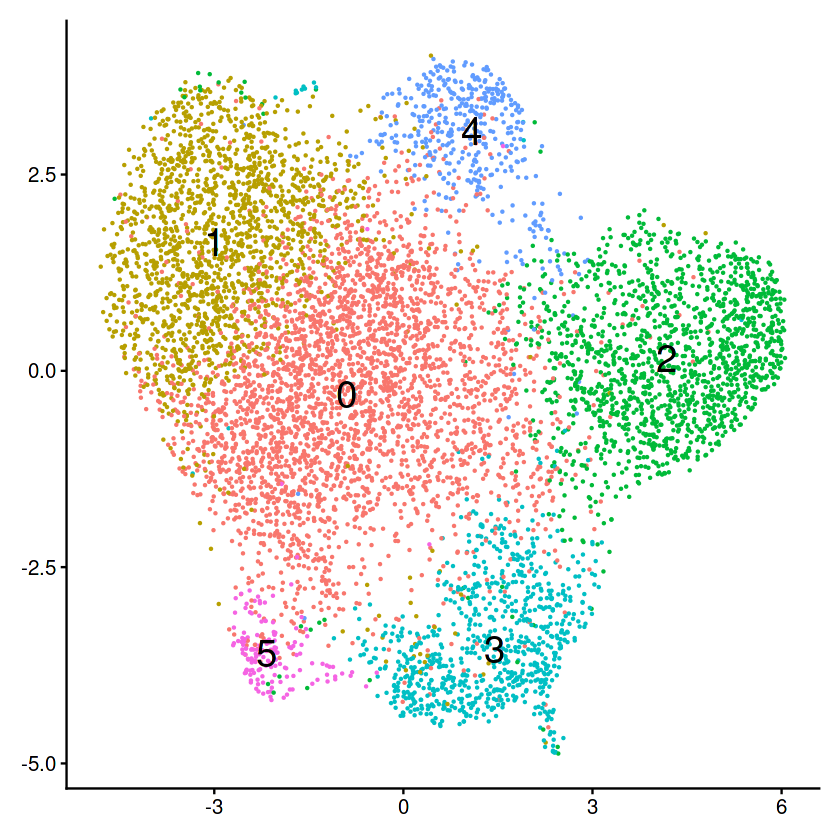

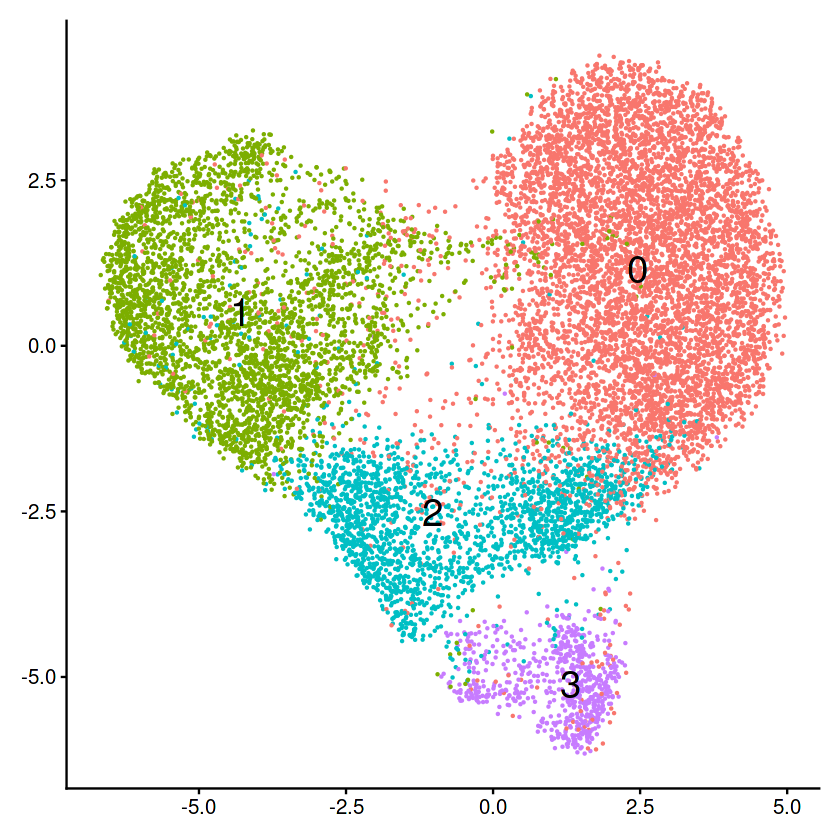

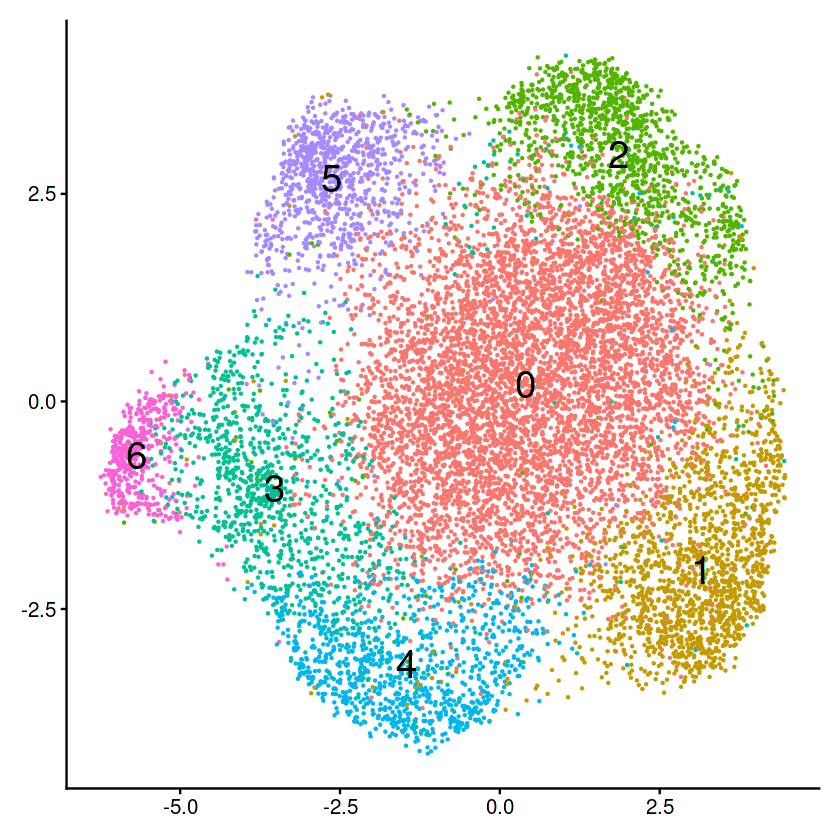

In [9]:
###Figure 3B, Protting the result of dimentional reduction

dir.name <- "3B"
sample.basename <- "Fig3B.umap.tiff"

################################# Processing layer ##########################################
dir.create(dir.name)

for(i in 1:length(conditions)){
    #Call seurat object and condition name
    seu <- seu.list[[i]]
    condition <- conditions[i]
    file.name <- str_c(condition, sample.basename, sep = "_")

    #Output twice size of figure, compress after pasting in the powerpoint.
    p1 = DimPlot(object = seu, reduction = "umap", label = TRUE, label.size = 8, pt.size = 0.2) +
      theme(axis.title.x = element_blank(), 
            axis.title.y = element_blank(), 
            axis.text.x = element_text(size=12, colour = 1, family = "Arial"), 
            axis.text.y = element_text(size = 12, colour = 1, family = "Arial")) +
      theme(panel.border = element_rect(fill = NA, size = 1.5)) 

    p1 = p1 + theme(legend.position = 'none')
    name.output <- str_c(dir.name, file.name, sep = "/")
    save_plot(file = name.output, plot(p1), device="tiff", 
              units="in", dpi = 300, base_width = 3.9, base_height = 3.9, limitsize=FALSE)
}

In [23]:
str(p$guides)

List of 2
 $ colour:List of 29
  ..$ title          : chr "Ave."
  ..$ title.position : NULL
  ..$ title.theme    : NULL
  ..$ title.hjust    : NULL
  ..$ title.vjust    : NULL
  ..$ label          : logi TRUE
  ..$ label.position : NULL
  ..$ label.theme    : NULL
  ..$ label.hjust    : NULL
  ..$ label.vjust    : NULL
  ..$ barwidth       : NULL
  ..$ barheight      : NULL
  ..$ nbin           : num 300
  ..$ raster         : logi TRUE
  ..$ frame.colour   : NULL
  ..$ frame.linewidth: num 0.5
  ..$ frame.linetype : num 1
  ..$ ticks          : logi TRUE
  ..$ ticks.colour   : chr "white"
  ..$ ticks.linewidth: num 0.5
  ..$ draw.ulim      : logi TRUE
  ..$ draw.llim      : logi TRUE
  ..$ direction      : NULL
  ..$ default.unit   : chr "line"
  ..$ reverse        : logi FALSE
  ..$ order          : num 1
  ..$ available_aes  : chr [1:3] "colour" "color" "fill"
  ..$ breaks         : num [1:5] -2 -1 0 1 2
  ..$ name           : chr "colorbar"
  ..- attr(*, "class")= chr [1:2] "guide

Warning message in dir.create(dir.name):
“'3C' already exists”
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



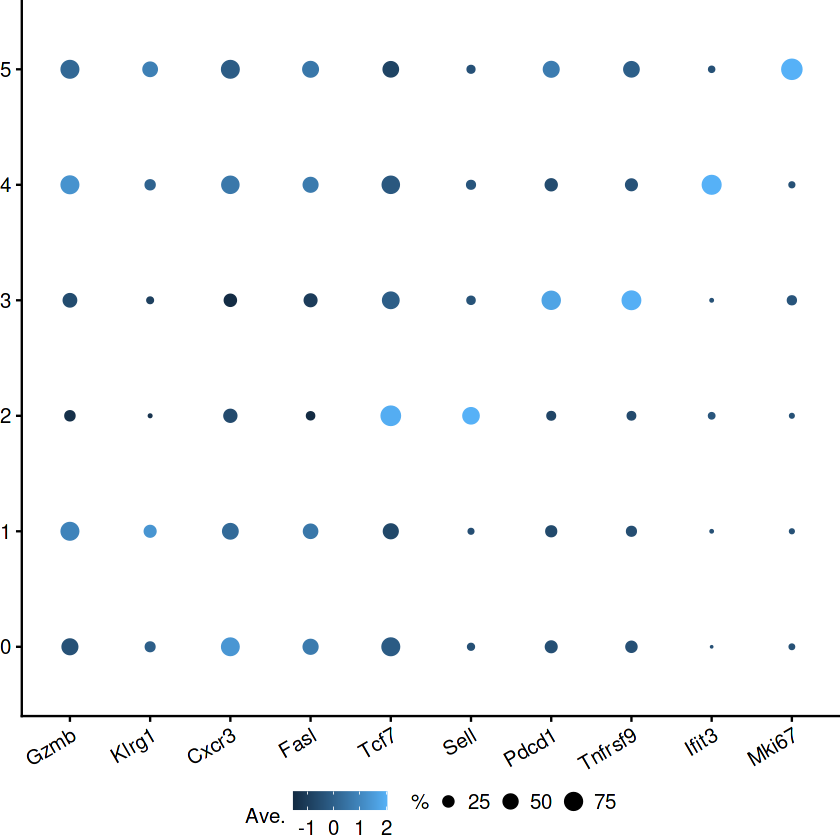

In [56]:
###Figure 3C, Baloon plot for marker genes

dir.name <- "3C"
sample.basename <- "Fig3C.BaloonPlot.tiff"
genes.cont <- c("Gzmb", "Klrg1", "Cxcr3", "Fasl", "Tcf7", "Sell", "Pdcd1", "Tnfrsf9", "Ifit3", "Mki67")
genes.aPDL1 <- c("Lef1", "Sell", "Tcf7", "Cd74", "Pdcd1", "Havcr2", "Gzma", "Tnfrsf9", "Cxcr3", "Ifit3")
genes.aCD4 <- c("Pdcd1", "Havcr2", "Gzmb", "Mki67", "Gzmk", "Tcf7", "Ifng", "Tnfrsf9", "Isg15", "Sell")
gene.list <- list(genes.cont, genes.aPDL1, genes.aCD4)

#breaks for legend color bar
bar.cont <- c(-1, 0, 1, 2)
bar.apdl1 <- c(-1, 0, 1)
bar.acd4 <- c(-2, -1, 0, 1, 2)
bar.list <- list(bar.cont, bar.apdl1, bar.acd4)

################################# Processing layer ##########################################
dir.create(dir.name)

for(i in 1:length(conditions)){
    #Call seurat object and condition name
    seu <- seu.list[[i]]
    condition <- conditions[i]
    file.name <- str_c(condition, sample.basename, sep = "_")
    genes <- gene.list[[i]]
    bar <- bar.list[[i]]
    
    ppi <- 300
    name.output <- str_c(dir.name, file.name, sep = "/")
    p <- DotPlot(seu, features = genes, cols = c("lightgrey", "blue"),
            dot.min = 0, dot.scale = 5,
            scale.by = "size", scale.min = NA, scale.max = NA) +
      theme(axis.title = element_blank(), 
            axis.text.y = element_text(size=12, colour = 1, family = "Arial"),
            axis.text.x = element_text(size=12, colour = 1, family = "Arial", angle = 30, hjust = 1)) + 
        scale_colour_continuous(breaks =bar) +
      theme(panel.border = element_rect(fill = NA, size = 0.1),
            legend.position = "bottom",
            legend.key.width = unit(0.4, "cm"),
            legend.key.height = unit(0.4, "cm"),
            legend.justification = "top",
            legend.text = element_text(size=12, colour = 1, family = "Arial"),
            legend.title = element_text(size=12, colour = 1, family = "Arial"),
            legend.margin=margin(0,0,0,0),
            legend.box.margin=margin(-5,-5,0,-5),
            plot.margin = unit(c(0, 0, 0, 0), "cm")) +
        guides(colour = guide_colourbar(order=1, breaks=seq(-2,2,1)),
               size = guide_legend(order=2))
    p$guides$colour$title <- "Ave."
    p$guides$size$title <- "%"
    file.name <- str_c(dir.name, file.name, sep="/")
    save_plot(file = file.name, plot(p), device="tiff", 
              units="in", dpi = 600, base_width = 3.8, base_height = 2.8, limitsize=FALSE)
    plot(p)
    dev.off()
}

In [26]:
#Figure3D: Plot clones of Oligoclonal / Polyclonal fraction in Dimplot

modules <- c("Oligo", "Poly")
dir.name <- "3D"
#Specify clone table merged with dLN overlap status
basename.clone.table <- "scTCR.dLNOL.csv"

############################# Processing layer ######################################
dir.create(dir.name)

for(i in 1:length(conditions)){
    #Call seurat object and condition name
    seu <- seu.list[[i]]
    condition <- conditions[i]
    file.name <- str_c(condition, sample.basename, sep = "_")

    #Call clone table merged with dLN overlap status (Stored in "scTCR_WGCNA_combine" directory)
    name.clone.table <- str_c("scTCR_analysis", condition, sep = "/") %>% str_c(basename.clone.table, sep = ".")
    clone_within_cluster <- read.csv(name.clone.table, header = TRUE)

    #Call metadata and extract cell names
    meta.data <- as.data.frame(seu@meta.data)
    tmp_raw <- as.vector(row.names(meta.data))

    #Output twice size of figure, compress after pasting in the powerpoint.
    for(i in modules){
        #Extract clones in each subset
        clone_plot <- dplyr::filter(clone_within_cluster, OL == i)
        clone_names <- clone_plot$names

        #Extract cell names for Dimplot
        data_sub <- dplyr::filter(meta.data, clone.id.TCRb %in% clone_names)
        clone.id <- as.vector(row.names(data_sub))
        tmp2 = tmp_raw %in% clone.id

        #Output
        name.output <- str_c(dir.name, condition, sep = "/") %>% str_c(i, "clone.plot.tiff", sep = ".")
        PlotClones(seu, tmp2, name.output, meta.data, clone_plot, "umap", 2.2)
    }
}

Warning message in dir.create(dir.name):
“'3D' already exists”


### Figure S2

In [14]:
#FigureS2A: Violin plot for Signature Score

#Specify clone table merged with dLN overlap status
dir.name <- "S2A"
#Specify clone table merged with dLN overlap status
basename <- "Signature.Violin.tiff"
Sig_array <- c("Tumor.Prog1", "Tumor.Term1", "Cytotoxicity1")

############################# Processing layer ######################################
dir.create(dir.name)

for(i in 1:length(conditions)){
    #Call seurat object and condition name
    seu <- seu.list[[i]]
    condition <- conditions[i]
    
    #Create Violin Plot
    name.output <- str_c(dir.name, condition, sep = "/") %>% str_c(basename, sep = ".")
    ppi <- 600
    tiff(name.output, width=2*ppi, height=2.8*ppi, res=ppi)
    p <- StackedVlnPlot(obj = seu, features = Sig_array, pt.size = 0)
    plot(p)
    dev.off()
}

Warning message in dir.create(dir.name):
“'S2A' already exists”
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



In [21]:
###Figure S2B: Calculate clonality of TCR repertoire per clusters

#Specify clone table merged with dLN overlap status
output.basename <- "clonality.csv"
input.basename  <- "scTCR.dLNOL.csv"
dir.input <- "scTCR_analysis"
dir.name <- "S2B"

############################# Processing layer ######################################
dir.create(dir.name)

for(i in 1:length(conditions)){
    #Call seurat object and condition name
    condition <- conditions[i]
    
    name.input <- str_c(dir.input, condition, sep = "/") %>% str_c(input.basename, sep = ".")
    d <- read.csv(name.input, header = TRUE)
    
    #Extract cluster distribution information
    d_clusts <- dplyr::select(d, starts_with("X"))
    clust.array <- names(d_clusts)
    
        #Calculate clonality
    output <- data.frame()
    for(i in 1:length(clust.array)){
      clust <- clust.array[i]
      d_sub <- select(d, clust)
      names(d_sub) <- "count"
      d_sub <- filter(d_sub, count > 0)
      d_sub$freq <- d_sub$count / sum(d_sub$count)

      ##Calculate median and count clonotypes
      l <- length(d_sub$freq)
      count <- sum(d_sub$count)

      #Calculate 1-Pielou clonality
      e <- log(d_sub$freq)
      pi <- 1+sum(d_sub$freq * e)/log(length(d_sub$freq))

      out <- c(l, count, pi)

      output <- rbind(output, out)
    }

    names(output) <- c("clones", "cells", "Pielou")
    output$cluster <- clust.array

    name.output <- str_c(dir.name, condition, sep = "/") %>% str_c(output.basename, sep = ".")

    write.csv(output, name.output, row.names = F)
    
}

Warning message in dir.create(dir.name):
“'S2B' already exists”
Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(clust)` instead of `clust` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


In [28]:
#Figure S2C,D: Correlation analysis between gene score and clone size
#Input; scTCR_analysis/clone_within_cluster.dLNOL.csv

file.basename  <- "scTCR.dLNOL.csv"
dir.input <- "scTCR_analysis"
dir.name <- "S2CD"

############################# Processing layer ######################################
dir.create(dir.name)

output.table <- data.frame()
for(i in 1:length(conditions)){
    #Call seurat object and condition name
    condition <- conditions[i]
    
    #Load clone table
    name.input <- str_c(dir.input, condition, sep = "/") %>% str_c(file.basename, sep = ".")
    d <- read.csv(name.input, header = TRUE)
    d_sub <- dplyr::select(d, c("temp_freq", "Tumor.Prog1", "Tumor.Term1", "OL"))
    d_sub <- dplyr::filter(d_sub, temp_freq > 0.001)
    d_sub <- dplyr::filter(d_sub, OL %in% c("Poly", "Oligo"))

    axis_x <- "temp_freq"
    axis_y <- c("Tumor.Prog1", "Tumor.Term1")

    #Convert frequency to percentage
    d_sub$temp_freq <- d_sub$temp_freq*100

    #Calculate correation coefficient
    col.names <- c("pvalue", "rvalue", "cor_abs")
    output <- createEmptyDf(length(axis_y), length(col.names), colnames = col.names )
    for(j in 1:length(axis_y)){
        #Extract data
        y_param <- axis_y[j]
        d_sub2 <- dplyr::select(d_sub, c("OL", axis_x, y_param))
        names(d_sub2) <- c("OL", "x_axis", "y_axis")

        #Calculate correlation coefficient
        result.name <- str_c(dir.name, "Genescore.correlation.txt", sep = "/")
        cor_t <- cor.test(log10(d_sub2$x_axis), d_sub2$y_axis, use="pairwise", method="pearson")

        #Record pvalues
        output[j,1] <- cor_t$p.value
        output[j,2] <- cor_t$estimate
        output[j,3] <- abs(cor_t$estimate)
    }
    output$param <- axis_y
    output$condition <- condition
    
    output.table <- rbind(output.table, output)

    
    #Freq vs Tumor.prog
    j <- "Tumor.Prog1"
    d_sub2 <- dplyr::select(d_sub, c("OL", axis_x, j))
    names(d_sub2) <- c("OL", "x_axis", "y_axis")
    ppi <- 600
    name_out <- str_c(dir.name, condition, sep = "/") %>% str_c("x", axis_x, "y", j, "tiff", sep = ".")
    tiff(name_out, width=0.9*ppi, height=1*ppi, res=ppi)
    p <- ggplot(d_sub2, aes(x=x_axis, y=y_axis, colour=OL)) +
        scale_colour_manual(values=c(Poly="blue", Oligo="red"))+
        geom_point(size=0.4) +
        scale_x_log10() +
          theme_bw(base_size = 6) +
          theme(
            axis.title.x=element_blank(), axis.title.y=element_blank(),
            axis.text.x = element_text(size=6, family="Arial"),
            axis.text.y = element_blank()) +
          guides(colour=FALSE)
    plot(p)
    dev.off()

    #Freq vs Tumor.term
    j <- "Tumor.Term1"
    d_sub2 <- dplyr::select(d_sub, c("OL", axis_x, j))
    names(d_sub2) <- c("OL", "x_axis", "y_axis")
    ppi <- 600
    name_out <- str_c(dir.name, condition, sep = "/") %>% str_c("x", axis_x, "y", j, "tiff", sep = ".")
    tiff(name_out, width=0.9*ppi, height=1*ppi, res=ppi)
    p <- ggplot(d_sub2, aes(x=x_axis, y=y_axis, colour=OL)) +
        scale_colour_manual(values=c(Poly="blue", Oligo="red"))+
        geom_point(size=0.4) +
        scale_x_log10() +
          theme_bw(base_size = 6) +
          theme(
            axis.title.x=element_blank(), axis.title.y=element_blank(),
            axis.text.x = element_text(size=6, family="Arial"),
            axis.text.y = element_blank()) +
          guides(colour=FALSE)
    plot(p)
    dev.off()
}

name.output <- str_c(dir.name, "correlation.value.csv", sep = "/")
write.csv(output.table, name.output)

Warning message in dir.create(dir.name):
“'S2CD' already exists”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


In [30]:
###Figure S2E: Extract DEGs between Oligoclonal vs Polyclonal fractions

#Specify clone table merged with dLN overlap status
file.basename  <- "scTCR.dLNOL.csv"
dir.input <- "scTCR_analysis"
dir.name <- "S2E"
clones_array <- c("Oligo", "Poly")
#Target for DEG analysis
Subset1 <- "Oligo"
Subset2 <- "Poly"

############################# Processing layer ######################################
dir.create(dir.name)
for(i in 1:length(conditions)){
    #Call seurat object and condition name
    seu <- seu.list[[i]]
    condition <- conditions[i]
    
    #Load clone table
    name.input <- str_c(dir.input, condition, sep = "/") %>% str_c(file.basename, sep = ".")
    d <- read.csv(name.input, header = TRUE)
    
    #Call meta.data and cell names
    meta.data <- as.data.frame(seu@meta.data)
    tmp_raw <- as.vector(row.names(meta.data))

    #Integrate OL status into meta.data
    meta.data$class <- "nd"
    for(i in clones_array){
        #Extract clones in each subset
        clone_plot <- dplyr::filter(d, OL == i)
        clone_names <- clone_plot$names

        #Extract cell names belonging to clones
        data_sub <- dplyr::filter(meta.data, clone.id.TCRb %in% clone_names)
        clone.id <- as.vector(row.names(data_sub))
        tmp2 = tmp_raw %in% clone.id

        #Reflect to meta.data
        meta.data$class[tmp2] <- i
    }

    #Substitute OL status for "ident"
    ident <- seu@active.ident 
    names.ident <- names(ident)
    ident <- as.factor(meta.data$class)
    names(ident) <- names.ident
    seu@active.ident <- ident

    #DEG extracton
    DEG.subset.1 = FindMarkers(seu, ident.1 = Subset1, ident.2 = Subset2,
                               test.use="wilcox", only.pos=TRUE, min.pct=0.1,
                               features.use = NULL, nthreads = 12,
                               adj.p.val.threshold=0.05)
    name.output <- str_c(dir.name, condition, sep = "/") %>% str_c(Subset1, "Up.csv", sep = ".")
    write.csv(DEG.subset.1, name.output, row.names = TRUE)

    DEG.subset.2 = FindMarkers(seu, ident.1 = Subset2, ident.2 = Subset1,
                               test.use="wilcox", only.pos=TRUE, min.pct=0.1,
                               features.use = NULL, nthreads = 12,
                               adj.p.val.threshold=0.05)
    name.output <- str_c(dir.name, condition, sep = "/") %>% str_c(Subset2, "Up.csv", sep = ".")
    write.csv(DEG.subset.2, name.output, row.names = TRUE)
}






Warning message in dir.create(dir.name):
“'S2E' already exists”
